In [4]:
import os
import sys
import re
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Audio
from pydub import AudioSegment, effects
import noisereduce as nr
from tqdm import tqdm
from sklearn.utils import shuffle
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, PolarityInversion, TimeMask, FrequencyMask, SpecFrequencyMask, RoomSimulator, AddBackgroundNoise
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import parselmouth 
from parselmouth import praat
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

In [6]:
MAX_LENGTH = 48000
FRAME_LENGTH = 2048
HOP_LENGTH = 512
TOP_DB = 25
RATE = 16000

In [7]:
Crema_Path='../Datasets/Crema/'
Ravdess_Path='../Datasets/Ravdess/'
Savee_Path='../Datasets/Savee/'
Tess_Path='../Datasets/Tess/'

In [8]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'emotion',1:'sound'},inplace=True)
Crema_df.head()

,emotion,sound
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav


In [9]:
Crema_df['emotion'].unique()

array(['angry', 'fear', 'happy', 'disgust', 'sad', 'neutral'],
      dtype=object)

In [10]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'emotion',1:'sound'},inplace=True)
Ravdess_df['emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,emotion,sound
0,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-01-01...
1,sad,../Datasets/Ravdess/Actor_08/03-01-04-02-02-02...
2,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-02-01...
3,happy,../Datasets/Ravdess/Actor_08/03-01-03-01-02-01...
4,fear,../Datasets/Ravdess/Actor_08/03-01-06-01-02-02...


In [11]:
Ravdess_df['emotion'].unique()


array(['neutral', 'sad', 'happy', 'fear', 'disgust', 'angry', 'surprise'],
      dtype=object)

In [12]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'emotion',1:'sound'},inplace=True)
Savee_df.head()

,emotion,sound
0,fear,../Datasets/Savee//KL_f05.wav
1,disgust,../Datasets/Savee//KL_d11.wav
2,neutral,../Datasets/Savee//DC_n06.wav
3,disgust,../Datasets/Savee//DC_d06.wav
4,surprise,../Datasets/Savee//DC_su06.wav


In [13]:
Savee_df['emotion'].unique()

array(['fear', 'disgust', 'neutral', 'surprise', 'angry', 'sad', 'happy'],
      dtype=object)

In [14]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'emotion',1:'sound'},inplace=True)
Tess_df.head()

,emotion,sound
0,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_dab...
1,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_mak...
2,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_bea...
3,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_hal...
4,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_pas...


In [15]:
Tess_df['emotion'].unique()

array(['surprise', 'fear', 'sad', 'disgust', 'angry', 'neutral', 'happy'],
      dtype=object)

In [16]:
df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df], axis=0, ignore_index=True)
df = df[df['emotion'] != 'surprise']
df.shape

(11510, 2)

In [17]:
def get_emotion_identifier(emo):
    return classes.index(emo)

In [18]:
df.sample(10)

,emotion,sound
7712,angry,../Datasets/Ravdess/Actor_16/03-01-05-02-02-01...
9319,fear,../Datasets/Savee//DC_f15.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
2214,neutral,../Datasets/Crema//1035_DFA_NEU_XX.wav
5211,happy,../Datasets/Crema//1076_ITS_HAP_XX.wav
5154,angry,../Datasets/Crema//1076_ITS_ANG_XX.wav
252,sad,../Datasets/Crema//1021_TAI_SAD_XX.wav
9944,sad,../Datasets/Tess/OAF_Sad/OAF_white_sad.wav
5641,neutral,../Datasets/Crema//1014_DFA_NEU_XX.wav
2927,neutral,../Datasets/Crema//1007_ITS_NEU_XX.wav


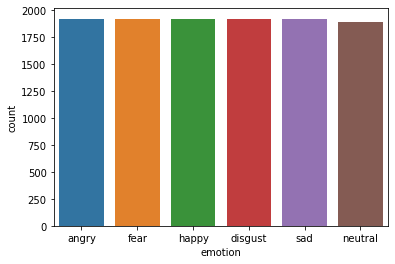

In [19]:
gm = sb.countplot(x='emotion', data=df)
# gm.fig.suptitle("Male")
plt.show()

#### ERD

In [20]:
def waveplot(data, sr, title):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.waveshow(data, sr=sr)
    plt.show()

def spectograph(data, sr, title):
    x = lr.stft(data)
    xdb = lr.amplitude_to_db(abs(x))
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def getPath(EType):
    return np.array(df['sound'][df['emotion'] == EType])[0]

def getInfo(EType):
    path = getPath(EType)
    data, sr = lr.load(path)
    waveplot(data, sr, EType)
    spectograph(data, sr, EType)


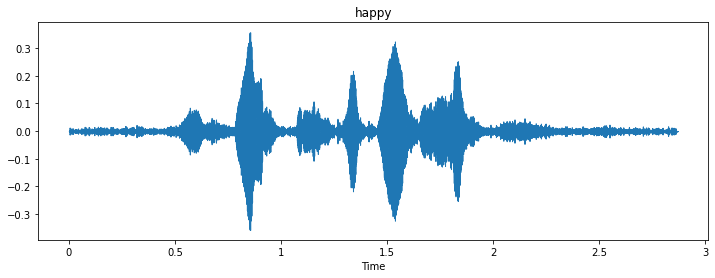

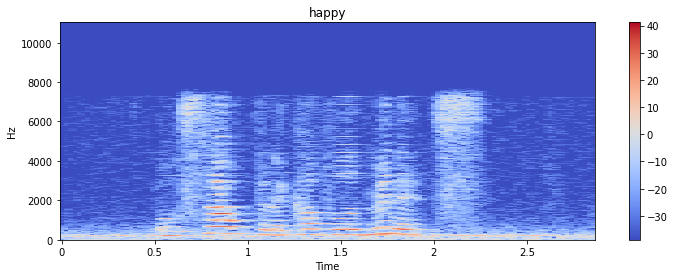

In [21]:
EType = 'happy'
getInfo(EType)
Audio(getPath(EType))

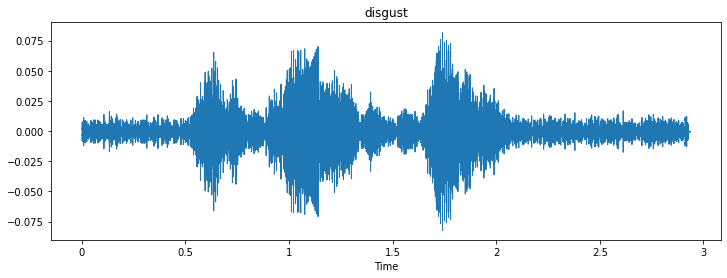

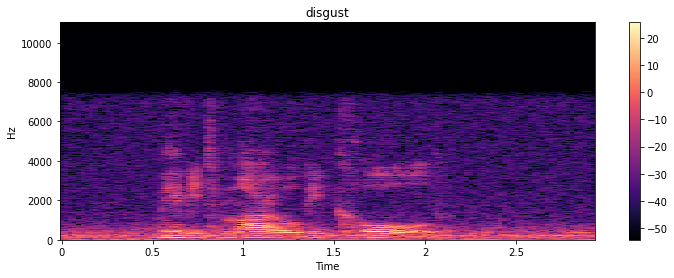

In [22]:
EType = 'disgust'
getInfo(EType)
Audio(getPath(EType))

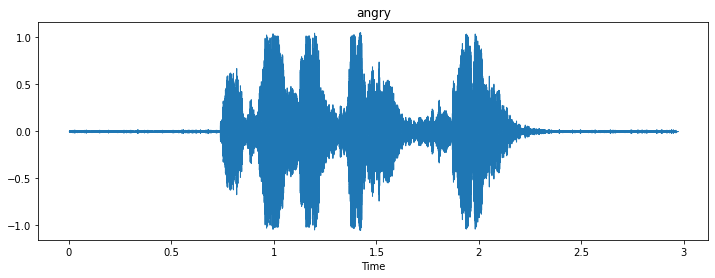

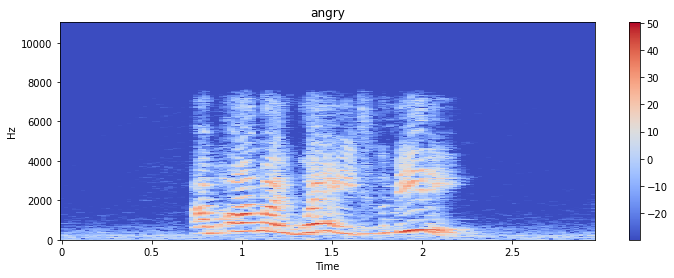

In [23]:
EType = 'angry'
getInfo(EType)
Audio(getPath(EType))

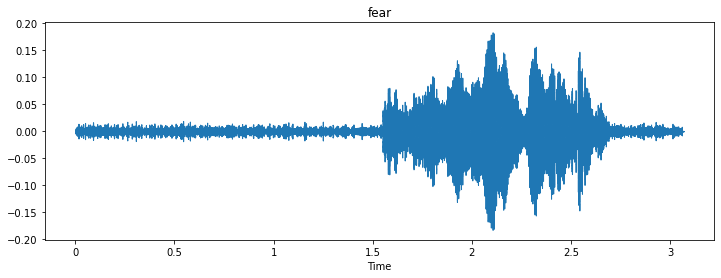

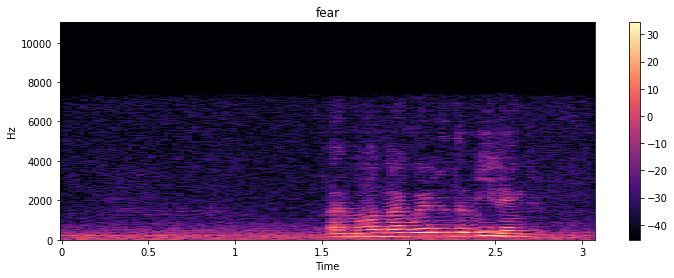

In [24]:
EType = 'fear'
getInfo(EType)
Audio(getPath(EType))

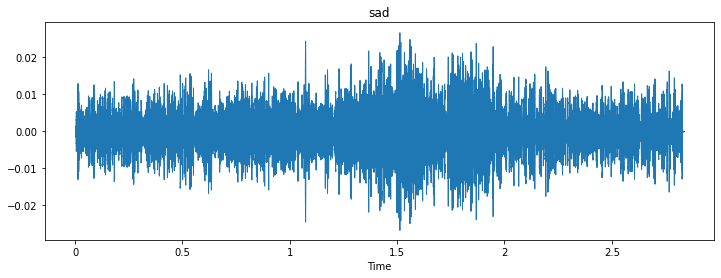

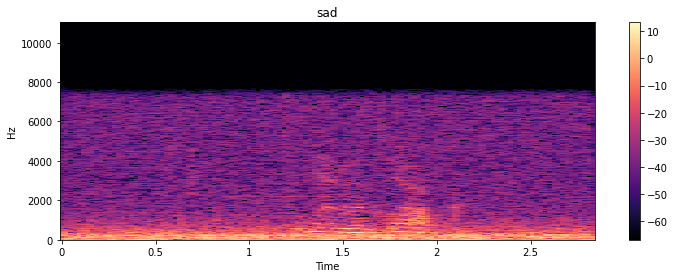

In [25]:
EType = 'sad'
getInfo(EType)
Audio(getPath(EType))

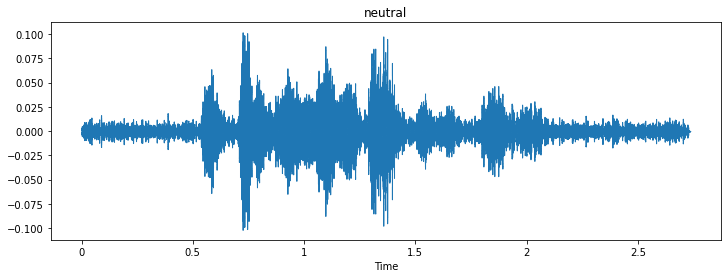

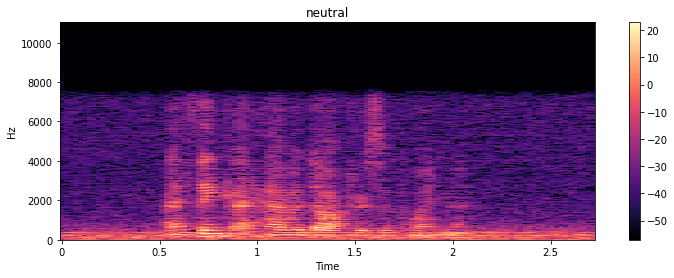

In [26]:
EType = 'neutral'
getInfo(EType)
Audio(getPath(EType))

# Data Augmentation

In [27]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def remove_noise(data):
    return nr.reduce_noise(data, sr=16000, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)

def stretch(data, rate=0.8):
    return lr.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return lr.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [28]:
# Data augmentation for training set only
# def augment(df: pd.DataFrame):
#     df_train_aug = p
    

## Data Augmentation Exhibition

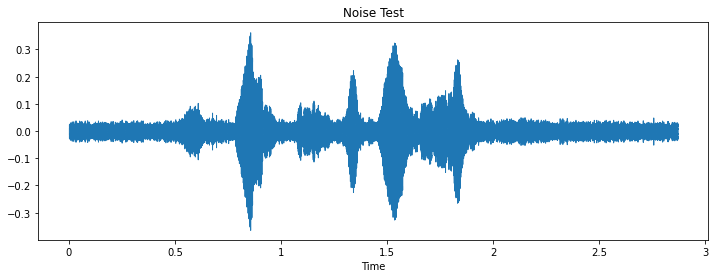

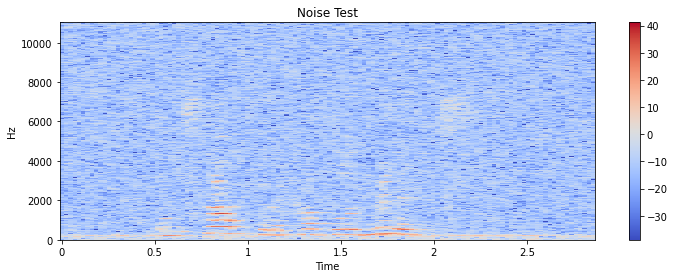

In [29]:
path = getPath('happy')
data, sr = lr.load(path)
x = noise(data)
waveplot(x, sr, 'Noise Test')
spectograph(x, sr, 'Noise Test')
Audio(x, rate=sr)

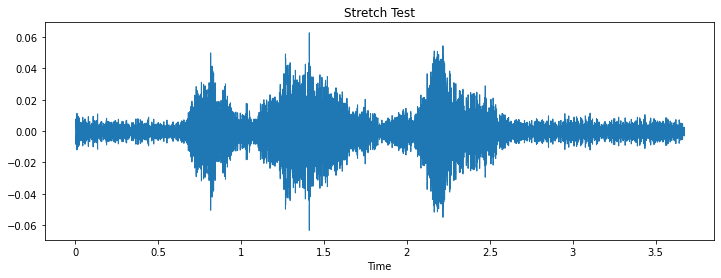

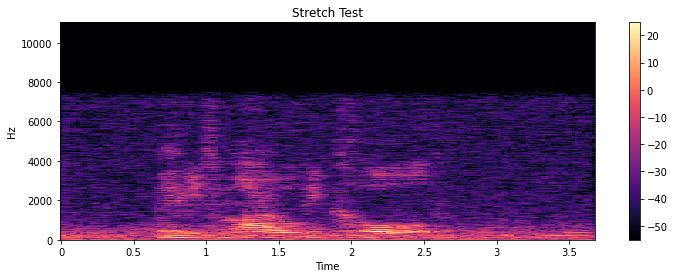

In [30]:
path = getPath('disgust')
data, sr = lr.load(path)
x = stretch(data)
waveplot(x, sr, 'Stretch Test')
spectograph(x, sr, 'Stretch Test')
Audio(x, rate=sr)

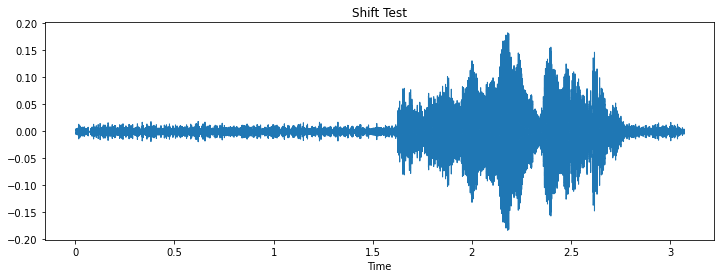

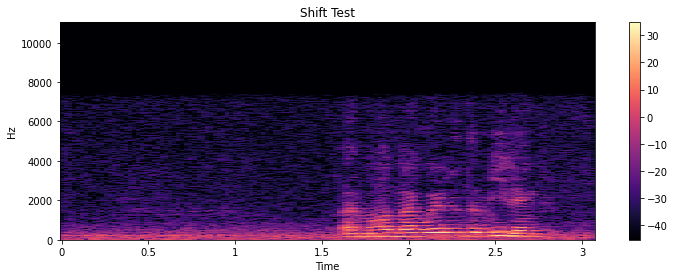

In [31]:
path = getPath('fear')
data, sr = lr.load(path)
x = shift(data)
waveplot(x, sr, 'Shift Test')
spectograph(x, sr, 'Shift Test')
Audio(x, rate=sr)

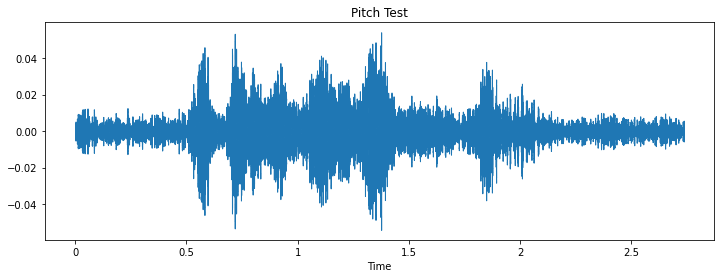

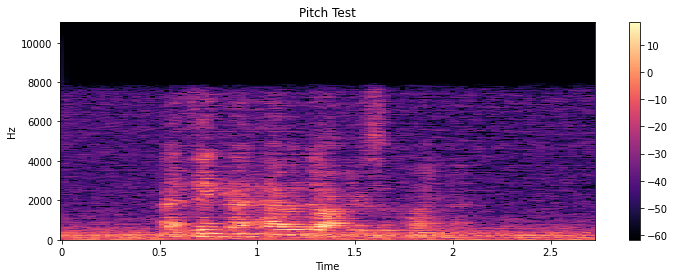

In [32]:
path = getPath('neutral')
data, sr = lr.load(path)
x = pitch(data, sr)
waveplot(x, sr, 'Pitch Test')
spectograph(x, sr, 'Pitch Test')
Audio(x, rate=sr)

In [33]:
## Shuffling
# d = d.sample(frac=1).reset_index(drop=True)
# d.head()

# Pre-processing

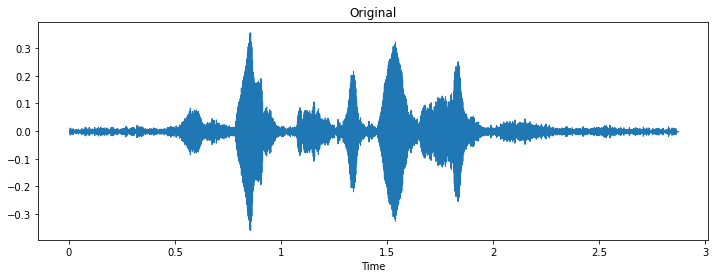

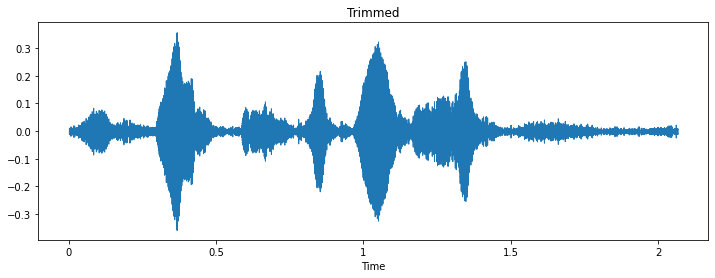

In [34]:
data, sr = lr.load(getPath('happy'))
waveplot(data, sr, 'Original')
data_t = lr.effects.trim(data, top_db=TOP_DB)
waveplot(data_t[0], sr, 'Trimmed')

In [35]:
def pre_process(path):


    data, sr = lr.load(path = path, sr=RATE, res_type='kaiser_best')

    # # Load the audio file.
    # rawsound = AudioSegment.from_file(path) 

    # # Normalize the audio to +5.0 dBFS.
    # normalizedsound = effects.normalize(rawsound, headroom = 0) 
    
    # # Transform the normalized audio to np.array of samples.
    # data = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

    # Trim silence from the beginning and the end.
    data, _ = lr.effects.trim(data, top_db=TOP_DB)

    if len(data) < MAX_LENGTH:
        data = np.pad(data, (0, MAX_LENGTH - len(data)), 'constant')
    else:
        data = data[:MAX_LENGTH]

    return data

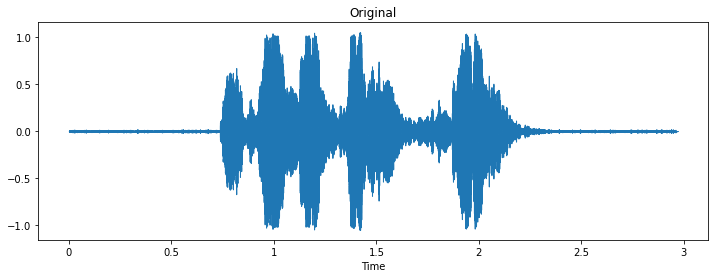

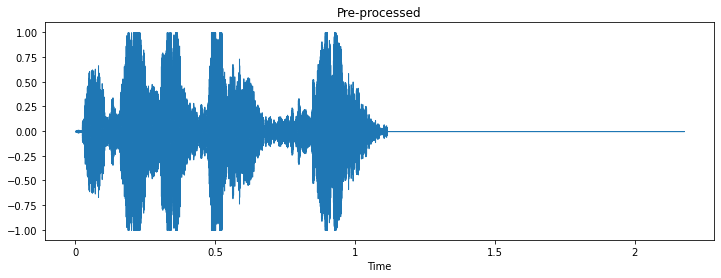

In [36]:
x = df['sound'][0]
data, sr = lr.load(x)
waveplot(data, sr, 'Original')
data_t = pre_process(x)
waveplot(data_t, sr, 'Pre-processed')

# Feature Extraction

In [37]:
def formants(file):
    sound = parselmouth.Sound(file) 
    f0min=75
    f0max=300
    pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    formants = praat.call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = praat.call(pointProcess, "Get number of points")
    f1_list = []
    f2_list = []
    for point in range(0, numPoints):
        point += 1
        t = praat.call(pointProcess, "Get time from index", point)
        f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        # f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
    # concat two lists and return
    return f1_list + f2_list


In [38]:
def zcr(data):
    zcr = lr.feature.zero_crossing_rate(data, frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)
    zcr = np.squeeze(zcr)
    return zcr

def mfcc(data, n_mfcc=13):
    mfcc =  lr.feature.mfcc(y=data, sr=RATE, n_mfcc=n_mfcc, hop_length=HOP_LENGTH)
    mfcc = np.mean(mfcc.T, axis=0)
    return mfcc

def mel(data, n_mels=40, flatten=True):
    mel = lr.feature.melspectrogram(data, sr=RATE, n_mels=n_mels, hop_length=HOP_LENGTH)
    return mel

def rms(data):
    rms = lr.feature.rms(data, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    rms = np.mean(rms.T, axis=0)
    return rms

def tonnetz(data):
    return lr.feature.tonnetz(data, sr=RATE, hop_length=HOP_LENGTH)

def spectral_contrast(data):
    return lr.feature.spectral_contrast(data, sr=RATE, hop_length=HOP_LENGTH)

def chroma(data, n_chroma=12):
    stft = lr.stft(data, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    return lr.feature.chroma_stft(S=stft, sr=RATE, hop_length=HOP_LENGTH, n_chroma=n_chroma)

In [39]:
d, s = lr.load(df['sound'][0], sr=RATE)
x = mfcc(d)
x.shape, x

((13,),
 array([-257.04324  ,   85.18567  ,   14.899784 ,   23.872898 ,
         -12.123879 ,   -5.322163 ,   -2.7682364,  -15.908816 ,
          -2.6014643,   -0.7426416,   -7.058485 ,   -8.753771 ,
          -2.9302936], dtype=float32))

In [40]:
# Feature extraction pipeline
def extract_features(data):

    result = np.array([])

    result=np.hstack((result,
                      zcr(data),
                      rms(data),
                      mfcc(data)
                     ))

    return result

In [41]:
# Wrapper function to preprocess and extract features from a list of files
def get_features(path):
    data = pre_process(path)
    return extract_features(data)

# Splitting and feature extraction

In [42]:
ds = 'all_en'
feat_ex_technique = 'formants'

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

def get_splits(d):
    # Produces test split.
    remaining, test = train_test_split(
        d, test_size=ratio_test, stratify=d['emotion'])

    # Adjusts val ratio, w.r.t. remaining dataset.
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining

    # Produces train and val splits.
    train, val = train_test_split(
        remaining, test_size=ratio_val_adjusted, stratify=remaining['emotion'])
        
    return train, val, test

In [43]:
train, val, test = get_splits(df)
train.shape, val.shape, test.shape

((8056, 2), (1727, 2), (1727, 2))

In [46]:
def get_feature_dataframe(df: pd.DataFrame, isAugment: bool = False):

    X_features = []
    y = []

    # for _, row in tqdm(df.iterrows()):
    #     feature = get_features(row['sound'])
    #     for ele in feature:
    #         X_features.append(ele)
    #         y.append(row['emotion'])

    # for _, row in tqdm(df.iterrows()):
    #     X_features.append(get_features(row['sound']))
    #     y.append(row['emotion'])

    for _, row in tqdm(df.iterrows()):
        X_features.append(formants(row['sound']))
        y.append(row['emotion'])
    
    X_features = pd.DataFrame(X_features)    
    y = pd.DataFrame(y)    

    X_features = X_features.fillna(0)

    # df_ft = pd.concat([X_features, y], axis=1)

    # df_ft = df_ft.set_axis([*df_ft.columns[:-1], 'emotion'], axis=1, inplace=False) # Renames last column

    # df_ft = df_ft.fillna(0)

    return X_features, y

In [50]:
# Testing
bruh, dead = get_feature_dataframe(df[:10])
bruh

10it [00:01,  6.84it/s]


,0,1,2,3,4,5,6,7,8,9,...,648,649,650,651,652,653,654,655,656,657
0,1208.505019,1332.174466,1231.231386,1025.595331,1016.046554,1006.447825,961.001299,909.671504,816.252921,666.294822,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,260.285030,258.726236,287.928741,336.519072,310.713222,265.613534,321.932028,240.917294,346.088019,271.405206,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,404.388138,549.245501,524.453906,501.636881,484.262027,472.370395,470.715856,464.740944,456.242763,450.999579,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,257.640378,250.945932,245.921354,246.196994,235.416202,240.080868,247.340598,248.761889,261.129589,250.037411,...,1705.989327,1719.066331,1704.59843,1642.999222,1480.833002,1594.800231,1728.663604,1759.082657,1652.478578,1644.740607
4,382.810770,409.175206,429.909864,439.311559,442.695406,442.667355,441.760260,442.130361,448.467944,460.368247,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,435.766551,437.304204,446.318535,456.660806,453.068457,570.534805,485.739493,454.350996,468.604206,461.333412,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,281.742489,321.593519,304.080248,265.679406,278.249716,270.667351,261.728231,386.777034,358.358180,317.604532,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,349.705027,289.554536,262.532912,350.206360,302.286008,284.281344,299.201299,325.247342,326.729443,314.540600,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,317.163407,327.054769,283.694120,251.460492,312.773664,325.152869,473.608675,322.706113,298.638566,313.267514,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,207.053563,404.079347,579.659655,482.062674,250.901395,259.398848,271.641128,259.100573,263.985989,274.660801,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
df_train, labels_train = get_feature_dataframe(train)
df_val, labels_val = get_feature_dataframe(val)
df_test, labels_test = get_feature_dataframe(test)

8056it [20:57,  6.40it/s]
1727it [04:28,  6.43it/s]
1727it [04:27,  6.46it/s]


In [54]:
df_train.shape, df_val.shape, df_test.shape

((8056, 1518), (1727, 1398), (1727, 1390))

In [56]:
m = max(df_train.shape[1], df_val.shape[1], df_test.shape[1])
# pad with zeros
df_train = np.pad(df_train, (0, m - df_train.shape[1]), 'constant')
df_val = np.pad(df_val, (0, m - df_val.shape[1]), 'constant')
df_test = np.pad(df_test, (0, m - df_test.shape[1]), 'constant')

In [57]:
df_train.shape, df_val.shape, df_test.shape

((8056, 1518), (1847, 1518), (1855, 1518))

In [123]:
# df_train.to_csv('./features/train_' + ds + '_' + feat_ex_technique + '.csv', index=False)
# df_val.to_csv('./features/val_' + ds + '_' + feat_ex_technique + '.csv', index=False)
# df_test.to_csv('./features/test_' + ds + '_' + feat_ex_technique + '.csv', index=False)

In [ ]:
# df_plot = pd.DataFrame(columns=['set', 'emotion'])

# x = pd.DataFrame(len(df_train['features']) * ['train'])
# y = pd.DataFrame(len(df_val['features']) * ['val'])
# z = pd.DataFrame(len(df_test['features']) * ['test'])

# p = pd.DataFrame(df_train['emotion'])
# q = pd.DataFrame(df_val['emotion'])
# r = pd.DataFrame(df_test['emotion'])

# df_plot['set'] = pd.concat([x ,y, z], axis=0, ignore_index=True)
# df_plot['emotion'] = pd.concat([p, q, r], axis=0, ignore_index=True)

# g = sb.catplot(x='emotion', col='set', data=df_plot, kind='count', hue='set', height=4, aspect=1.5)
# g.fig.suptitle("Number of sample per set")
# g.fig.subplots_adjust(top=.8)
# plt.show()

## Augmenting Training Data

In [ ]:
# train_aug = get_feature_dataframe(train, True)

In [ ]:
# df_train = pd.concat([df_train, train_aug], axis=0, ignore_index=True)

In [ ]:
# df_plot = pd.DataFrame(columns=['set', 'emotion'])

# x = pd.DataFrame(len(df_train['features']) * ['train'])
# y = pd.DataFrame(len(df_val['features']) * ['val'])
# z = pd.DataFrame(len(df_test['features']) * ['test'])

# p = pd.DataFrame(df_train['emotion'])
# q = pd.DataFrame(df_val['emotion'])
# r = pd.DataFrame(df_test['emotion'])

# df_plot['set'] = pd.concat([x ,y, z], axis=0, ignore_index=True)
# df_plot['emotion'] = pd.concat([p, q, r], axis=0, ignore_index=True)

# g = sb.catplot(x='emotion', col='set', data=df_plot, kind='count', hue='set', height=4, aspect=1.5)
# g.fig.suptitle("Number of sample per set (training set is augmented)")
# g.fig.subplots_adjust(top=.8)

In [ ]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

In [50]:
# save_path = f'./features/{ds}'
# # os.makedirs(save_path)

# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train', df_train['features'])
# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train_emo', df_train['emotion'])
# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val', df_val['features'])
# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val_emo', df_val['emotion'])
# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test', df_test['features'])
# np.save(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test_emo', df_test['emotion'])

In [51]:
# x_train = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train.npy')
# y_train = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train_emo.npy')
# x_val = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val.npy')
# y_val = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val_emo.npy')
# x_test = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test.npy')
# y_test = np.load(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test_emo.npy')

In [52]:
# x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((864, 256, 400),
 (864, 1),
 (360, 256, 400),
 (360, 1),
 (216, 256, 400),
 (216, 1))

In [ ]:
# save_path = f'./features/{ds}'
# os.makedirs(save_path)

# df_train.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_train.csv', index=False)
# df_val.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_val.csv', index=False)
# df_test.to_csv(f'{save_path}/{ds}_{feat_ex_technique}_{ratio_train}-{ratio_val}-{ratio_test}_test.csv', index=False)

In [58]:
scaler = StandardScaler()
x_train = scaler.fit_transform(df_train)
x_test = scaler.transform(df_test)
x_val = scaler.transform(df_val)
x_train.shape, labels_train.shape, x_test.shape, labels_test.shape, x_val.shape, labels_val.shape

((8056, 1518), (8056, 1), (1855, 1518), (1727, 1), (1847, 1518), (1727, 1))

In [59]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(labels_train).reshape(-1,1)).toarray()
y_val = encoder.fit_transform(np.array(labels_val).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(labels_test).reshape(-1,1)).toarray()
x_train.shape, labels_train.shape, x_test.shape, labels_test.shape, x_val.shape, labels_val.shape

((8056, 1518), (8056, 1), (1855, 1518), (1727, 1), (1847, 1518), (1727, 1))

In [60]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8056, 1518), (8056, 6), (1855, 1518), (1727, 6), (1847, 1518), (1727, 6))

In [65]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8056, 1518, 1),
 (8056, 6),
 (1855, 1518, 1),
 (1727, 6),
 (1847, 1518, 1),
 (1727, 6))

In [62]:
import tensorflow as tf

2022-09-06 18:38:57.337520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 18:38:57.337538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1516, 64)          256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 758, 64)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 756, 32)           6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 378, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12096)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [67]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
251/252 [============================>.] - ETA: 0s - loss: 1.6890 - accuracy: 0.2765

ValueError: Data cardinality is ambiguous:
  x sizes: 1847
  y sizes: 1727
Make sure all arrays contain the same number of samples.